In [13]:
import keras
import tensorflow as tf
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch
from tqdm import tqdm
from torchvision.models.inception import Inception3
import numpy as np
import matplotlib.pyplot as plt

In [19]:
from IPython.core.display import Image
from PIL import Image
import os

path = "/content/drive/MyDrive/VIP/data_road/" #Path of image data
train_path = path + "training/"
test_path = path + "testing/"

train_data = os.listdir(train_path + "image_2")
train_label = os.listdir(train_path + "gt_image_2")
test_data = os.listdir(test_path + "image_2")

class dataset(Dataset):
  def __init__(self,test=False,transf=transforms.ToTensor()):
    super().__init__()
    self.test=test
    self.trans = transf
    if test:
      self.data = test_data
    else:
      self.data = train_data
      self.labels = train_label

  def __len__(self):
      return len(self.data)

  def __getitem__(self, idx):
    if self.test:
      data_name = self.data[idx]
      data = Image.open(test_path + "image_2/" + data_name)
      data = data.resize((299, 299)) # Resize image first to fit dimension constraints on inception v3
      return self.trans(data), 0
    else:
      data_name = self.data[idx]
      label_name = self.labels[idx]
      data = Image.open(train_path + "image_2/" + data_name)
      label = Image.open(train_path + "gt_image_2/" + label_name)
      data = data.resize((299, 299)) 
      label = label.resize((299, 299)) 
      return self.trans(data), self.trans(label)

In [15]:
def train_model(model, data_loader, loss, optimizer, epochs):
  device=torch.device('cuda:0')
  model.to(device)
  model.train()
  loss_list=[]
  b_list=[]
  for epoch in range(epochs):
    print("Epoch: ", epoch)
    model.train()
    for data, label in tqdm(train_data_load):
      data=data.to(device)
      label = label.to(device)
      output=model(data)
      batch_loss=loss(output, label)
      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()
      b_list.append(batch_loss.cpu().detach().numpy())
    loss_list.append(sum(b_list)/len(b_list))
  return loss_list

In [16]:
class model(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer2=torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
    self.MaxPool2b=nn.MaxPool2d(3,2)
    self.AvgPool=nn.AdaptiveAvgPool2d((1,1))
    self.Upsample=nn.Upsample(scale_factor=(1.17,1.035)) 

    self.t_layer1=nn.ConvTranspose2d(768,256,kernel_size=3,stride=5)
    self.t_layer2=nn.ConvTranspose2d(256,64,3,5)
    self.t_layer3=nn.Conv2d(64,32,3,3)
    self.t_layer4=nn.ConvTranspose2d(32,16,3,5)
    self.t_layer5=nn.Conv2d(16,3,3,2)
    self.t_layer6=nn.Conv2d(3,3,3)
    


  def forward(self,x):
    if self.layer2.transform_input:
        x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
        x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
        x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
        x = torch.cat((x_ch0, x_ch1, x_ch2), 1)
    # N x 3 x 299 x 299
    x = self.layer2.Conv2d_1a_3x3(x)
    # N x 32 x 149 x 149
    x = self.layer2.Conv2d_2a_3x3(x)
    # N x 32 x 147 x 147
    x = self.layer2.Conv2d_2b_3x3(x)
    # N x 64 x 147 x 147
    x = self.MaxPool2b(x)
    # N x 64 x 73 x 73
    x = self.layer2.Conv2d_3b_1x1(x)
    # N x 80 x 73 x 73
    x = self.layer2.Conv2d_4a_3x3(x)
    # N x 192 x 71 x 71
    x = self.MaxPool2b(x)
    # N x 192 x 35 x 35
    x = self.layer2.Mixed_5b(x)
    # N x 256 x 35 x 35
    x = self.layer2.Mixed_5c(x)
    # N x 288 x 35 x 35
    x = self.layer2.Mixed_5d(x)
    # N x 288 x 35 x 35
    x = self.layer2.Mixed_6a(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6b(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6c(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6d(x)
    # N x 768 x 17 x 17
    x = self.layer2.Mixed_6e(x)
    
    # N x 256 x 85 x 85
    x=self.t_layer1(x)
    # N x 64 x 413 x 413 
    x=self.t_layer2(x)
    # N x 32 x 137 x 137 
    x=self.t_layer3(x)
    # N x 16 x 683 x 683 
    x=self.t_layer4(x)
    # N x 3 x 341 x 341
    x=self.t_layer5(x)
    # N x 3 x 299 x 299
    for i in range(21):
      x=self.t_layer6(x)

    return x



model=model()
loss=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters())

train_data=dataset()
train_data_load=DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)

loss_list=train_model(model, train_data_load, loss, optimizer, epochs=200) #Change number of epochs to train model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch:  0


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  1


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch:  2


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  3


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  4


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  5


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  6


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  7


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  8


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


Epoch:  9


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  10


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch:  11


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  12


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  13


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  14


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  15


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  16


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  17


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  18


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


Epoch:  19


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  20


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  21


100%|██████████| 18/18 [00:21<00:00,  1.17s/it]


Epoch:  22


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  23


100%|██████████| 18/18 [00:20<00:00,  1.17s/it]


Epoch:  24


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  25


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  26


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  27


100%|██████████| 18/18 [00:21<00:00,  1.21s/it]


Epoch:  28


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  29


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  30


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  31


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  32


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  33


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  34


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  35


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  36


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch:  37


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  38


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  39


100%|██████████| 18/18 [00:20<00:00,  1.14s/it]


Epoch:  40


100%|██████████| 18/18 [00:20<00:00,  1.13s/it]


Epoch:  41


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  42


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  43


100%|██████████| 18/18 [00:20<00:00,  1.16s/it]


Epoch:  44


100%|██████████| 18/18 [00:20<00:00,  1.11s/it]


Epoch:  45


100%|██████████| 18/18 [00:21<00:00,  1.20s/it]


Epoch:  46


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  47


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


Epoch:  48


100%|██████████| 18/18 [00:20<00:00,  1.12s/it]


Epoch:  49


100%|██████████| 18/18 [00:20<00:00,  1.15s/it]


In [20]:
model.eval()

test_data=dataset(test=True)
test_data_loader=DataLoader(test_data, batch_size=16, shuffle=True)

for data, _ in test_data_loader:
  device=torch.device('cuda:0')
  data=data.to(device)
  predictions=model(data)
  break

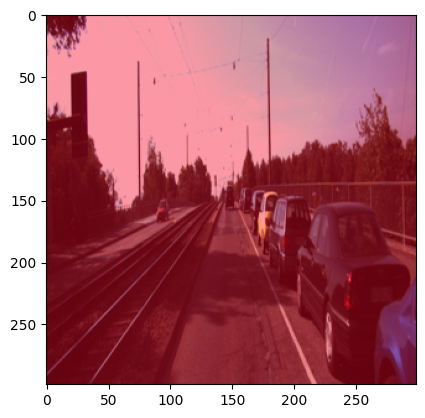

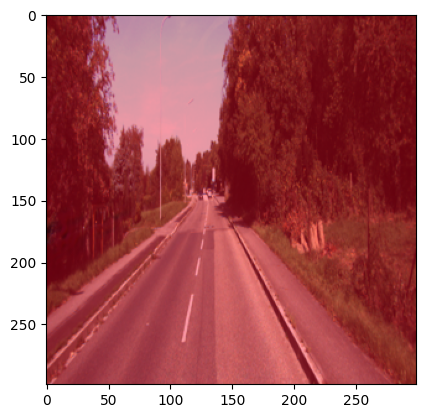

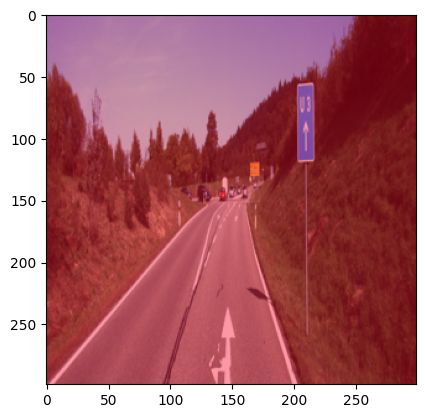

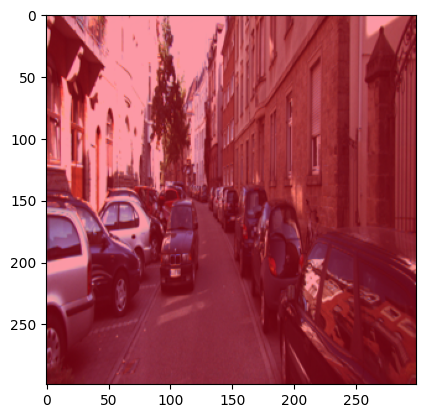

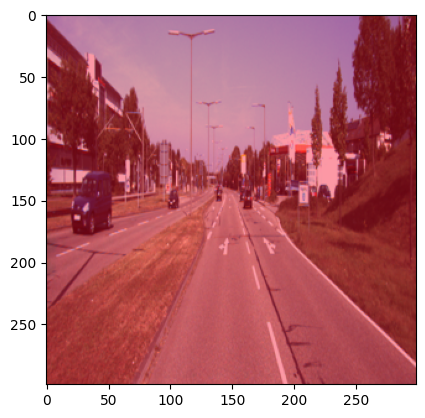

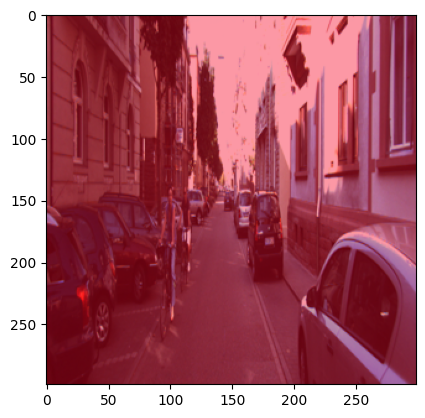

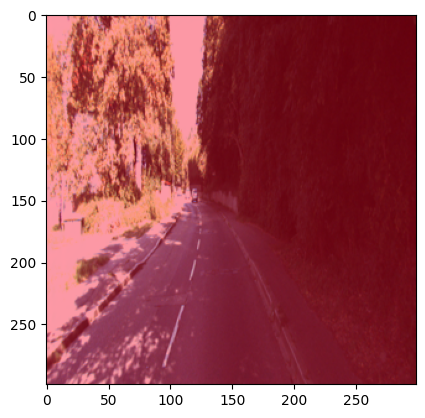

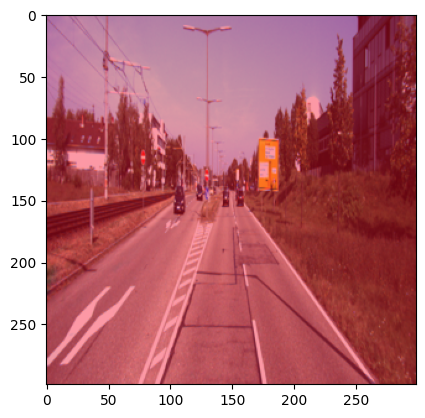

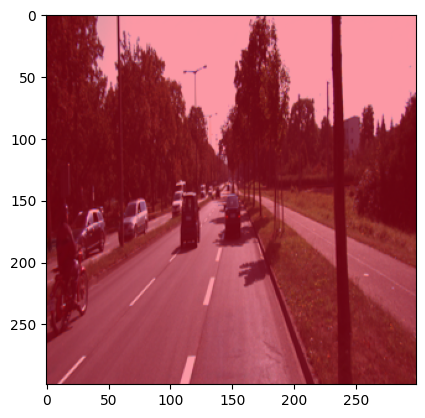

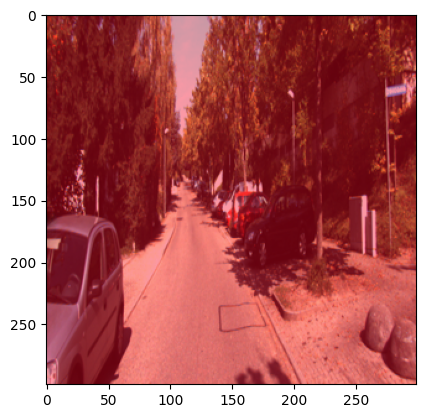

In [21]:
# Show superimposed image
for i in range(10):
  import matplotlib.pyplot as plt
  pred=predictions[i].permute(1,2,0)
  plt.imshow(pred.cpu().detach().numpy())

  test_img=data[i].permute(1,2,0)
  plt.imshow(test_img.cpu().detach().numpy(), alpha = 0.6)
  plt.show()